# **GPytorch Regression and Classification Tutorial**




The first step is to install gpytorch in google colab.




In [1]:
!pip install gpytorch

Defaulting to user installation because normal site-packages is not writeable


Now we are ready to use gpytorch's Gaussian processes for regression and classification. We can import the required python packages.

In [2]:
import math
import torch
import gpytorch
import numpy as np
from torch.nn import Parameter
from matplotlib import pyplot as plt
import torch

torch.set_default_dtype(torch.float64) 

## **Regression**

First, we consider the case in which the targets take values in the real line. Later on, we will explain how to use GPytorch for classification using the Laplace approximation.

### **Setting Up the Model**

The next cell demonstrates the most critical features of a Gaussian process model in GPyTorch. It provides the tools necessary to quickly construct a GP.

For most GP regression models, you will need to construct and use the following GPyTorch objects:

1. A GP Model (**gpytorch.models.ExactGP**) - This handles most of the inference.

2. A Likelihood (**gpytorch.likelihoods.GaussianLikelihood**) - This is the most common likelihood used for GP regression.

3. A Mean - This defines the prior mean of the GP. (If you don’t know which mean to use, a **gpytorch.means.ConstantMean\(\)** is a good place to start.)

4. A Kernel - This defines the prior covariance of the GP.(If you don’t know which kernel to use, a **gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel)** is a good place to start).

5. A MultivariateNormal Distribution (**gpytorch.distributions.MultivariateNormal**) - This is the object used to represent multivariate normal distributions.

### **The Model**

The components of a user built GP model in GPyTorch are, broadly speaking:

1. An **\_\_init\_\_** method that takes the training data and a likelihood, and constructs whatever objects are necessary for the model’s **forward** method. This will most commonly include things like a mean module and a kernel module.

2. A **forward** method that takes in some  data x and returns a **MultivariateNormal** with the prior mean and covariance evaluated at x. In other words, we return the vector  and the  matrix  representing the prior mean and covariance matrix of the GP.

In [3]:
# We create a class called ExactGPModel that inheritates from ExactGP and sets custom
# mean and covariance functions.

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with the corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### **The Likelihood**

The simplest likelihood for regression is the **gpytorch.likelihoods.GaussianLikelihood**. This assumes a homoskedastic noise model (i.e. all inputs have the same observational noise).

In [4]:
# initialize likelihood to be Gaussian.

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

### **Set Up the Training Data**

We set up the training data for this example. We’ll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.


In [5]:
# Training data are 100 points regularly spaced in the interval [0,1].

train_x = torch.linspace(0, 1, 100)

# True function is sin(2*pi*x) with additive Gaussian noise with variance 0.04.

train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)



We plot the generated data  for visualization.

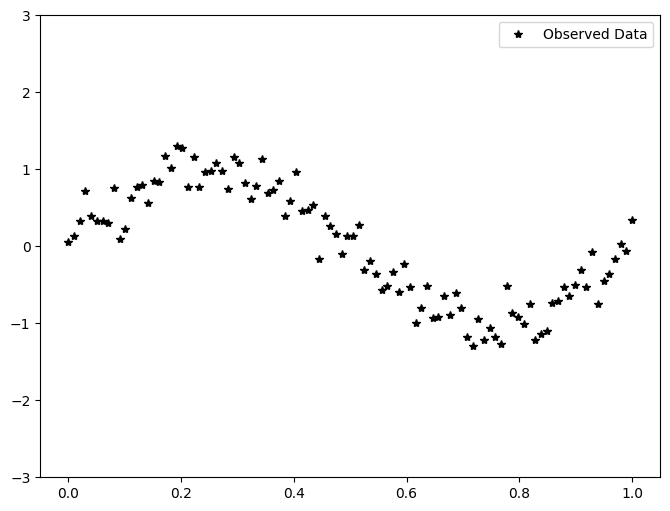

In [6]:
# Initialize plot

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot training data as black stars

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data'])

### **Creating the Model and Model Modes**

To create the model we only have to instantiate the previously defined class.



In [7]:
model = ExactGPModel(train_x, train_y, likelihood)

Like most PyTorch modules, the ExactGP has a **.train()** and **.eval()** mode. - **.train()** mode is for optimizing model hyperameters. - **.eval()** mode is for computing predictions through the model posterior. If the model is in **training mode**, its forward method will compute prior Gaussian parameters at the training data. If the model is in **eval mode**, its forward method will compute posterior Gaussian parameters at the input data. By default, the model is in training mode.

### **Sampling from the GP Prior**

We can sample from the GP prior simply by letting data go through the GP model in train mode.

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


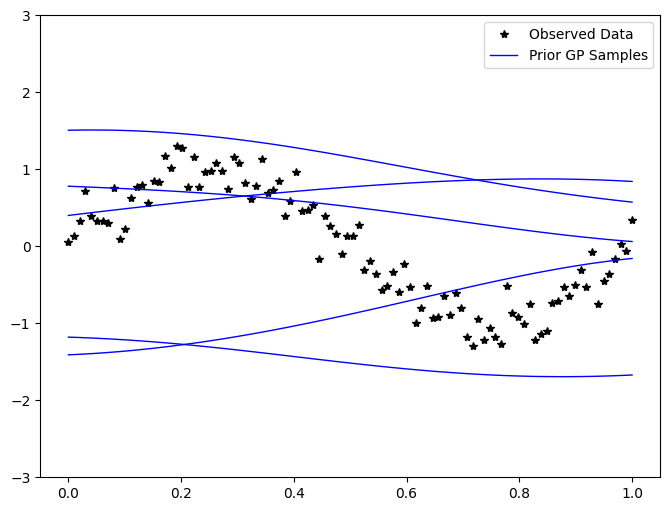

In [8]:
# We sample the prior process values at the training points simply by letting the data go through the GP model.
# This returns a Multivariate Gaussian distribution from which we can sample. We generate 5 samples and we plot
# them.

f, ax = plt.subplots(1, 1, figsize=(8, 6))

n_samples = 5

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

for i in range(n_samples):

  # We sample from the prior distribution of the process values at the training points.

  prior_sample = model(train_x).sample()

  # Plot training data as black stars

  ax.plot(train_x.numpy(), prior_sample.numpy(), color='blue',
     linewidth=1, markersize=1)

ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Prior GP Samples'])


### **Task 1: Asssess the Influence of the Kernel Hyper-parameters**

The samples from the prior look too smooth to have generated the observed data. Let us change the covariance function and the lengthscale parameter simply by doing the following:

In [9]:
model.covar_module.base_kernel.initialize(lengthscale = 0.01)

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)

Try different values for the length scales, i.e., \{0.01, 0.2, 0.5, 1.0, 10.0\}. Simply run the previous cell for each value, followed by the cell above that generates and plots the samples from the prior.

1. Indicate which lengthscale value is more likely to have generated the
observed data.
2. What values for the lengthscale lead to smoother functions?
3. What values for the lengthscale lead to more wiggling functions?
4. Run the code below to plot the corresponding predictive distribution.

### **Plotting the Posterior Predictive Distribution**

We obtain the parameters of the GP posterior predictive distribution simply by letting the data go through the model once it is in **eval** mode. Of course, we have to add the likelihood contribution to plot the predictive distribution for y. Otherwise, we will be computing the predictive distribution for the noiseless target value. The confidence region considered is the mean plus/minus 2 times the standard deviation.

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

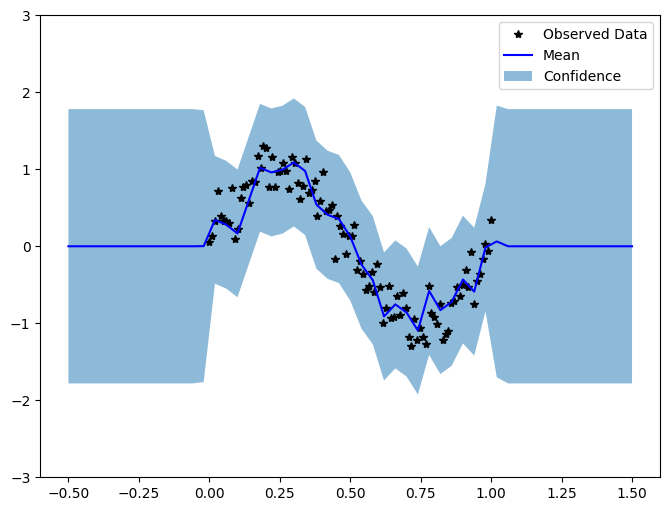

In [10]:
# Get into evaluation (predictive posterior) mode.

model.eval()
likelihood.eval()

# Test points are regularly spaced along [-0.5,1.5].
# Make predictions for y by feeding model through likelihood.

with torch.no_grad():
    test_x = torch.linspace(-0.5, 1.5, 51)
    predictions = likelihood(model(test_x))

# We plot the predictive distribution (mean +- standard deviation).

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get upper and lower confidence bounds

lower, upper = predictions.confidence_region()

# Plot training data as black stars

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

# Plot predictive means as blue line

ax.plot(test_x.numpy(), predictions.mean.numpy(), 'b')

# Shade between the lower and upper confidence bounds

ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

model.train()
likelihood.train()

### **Finding Good Model Hyper-parameters**

To find good model hyper-parameters one can simply maximize the marginal likelihood. Gpytorch provides a framework for this task that can be easily carried out. With this goal, we consider the zero mean prior and the RBF kernel.

In [11]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        # We set the initial value for the length-scale parameter

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# We create the model again with the new prior mean and covariance function.

model = ExactGPModel(train_x, train_y, likelihood)

To maximize the marginal likelhood we define that loss function and use the ADAM optimizer. Any other optimizer may be used for this purpose.

In [12]:
# We set the model mode to training.

model.train()
likelihood.train()

# Use instantiate the ADAM optimizer, which will optimize all model's parameters
# including the likelihood paramters, i.e., the noise variance.

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 200

for i in range(training_iter):

    # Zero gradients from previous iteration

    optimizer.zero_grad()

    # Compute model predictions prior predictions.

    output = model(train_x)

    # Calc loss and backprop gradients.

    loss = -mll(output, train_y)
    loss.backward()

    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))

    optimizer.step()

/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter 1/200 - Loss: 0.742   lengthscale: 0.693   noise: 0.100
Iter 2/200 - Loss: 0.637   lengthscale: 0.644   noise: 0.110
Iter 3/200 - Loss: 0.545   lengthscale: 0.598   noise: 0.120
Iter 4/200 - Loss: 0.463   lengthscale: 0.554   noise: 0.126
Iter 5/200 - Loss: 0.386   lengthscale: 0.513   noise: 0.128
Iter 6/200 - Loss: 0.314   lengthscale: 0.474   noise: 0.125
Iter 7/200 - Loss: 0.251   lengthscale: 0.439   noise: 0.120
Iter 8/200 - Loss: 0.199   lengthscale: 0.406   noise: 0.113
Iter 9/200 - Loss: 0.158   lengthscale: 0.377   noise: 0.106
Iter 10/200 - Loss: 0.127   lengthscale: 0.352   noise: 0.099
Iter 11/200 - Loss: 0.101   lengthscale: 0.329   noise: 0.091
Iter 12/200 - Loss: 0.081   lengthscale: 0.310   noise: 0.084
Iter 13/200 - Loss: 0.063   lengthscale: 0.294   noise: 0.078
Iter 14/200 - Loss: 0.049   lengthscale: 0.279   noise: 0.071
Iter 15/200 - Loss: 0.037   lengthscale: 0.267   noise: 0.066
Iter 16/200 - Loss: 0.027   lengthscale: 0.257   noise: 0.060
Iter 17/200 - Los

After training, we can compute predictions for the newly found hyper-parameters.

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

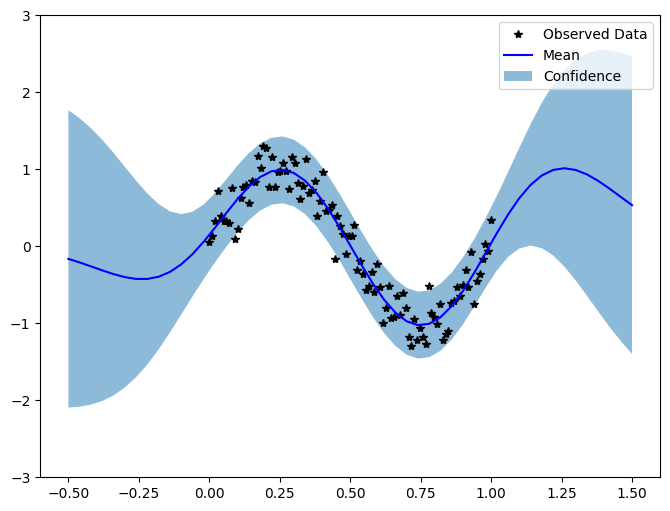

In [13]:
# Get into evaluation (predictive posterior) mode.

model.eval()
likelihood.eval()

# Test points are regularly spaced along [-0.5,1.5].
# Make predictions for y by feeding model through likelihood.

with torch.no_grad():
    test_x = torch.linspace(-0.5, 1.5, 51)
    predictions = likelihood(model(test_x))

# We plot the predictive distribution (mean +- standard deviation).

f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get upper and lower confidence bounds

lower, upper = predictions.confidence_region()

# Plot training data as black stars

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')

# Plot predictive means as blue line

ax.plot(test_x.numpy(), predictions.mean.numpy(), 'b')

# Shade between the lower and upper confidence bounds

ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

model.train()
likelihood.train()

### **Task 2: Influence of the covariance and mean function**

Changing the covariance and mean function of the GP has an effect on the prior samples and the posterior predictive distribution. To assess this, we will consider a linear mean (LinearMean\(\)) function and a different covariance function, e.g., the Matérn Covariance function (MaternKernel). For this, simply replace the class object defined before by:

In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a linear mean in one dimension with slope 2.0 and bias -1.0.

        self.mean_module = gpytorch.means.LinearMean(input_size = 1)
        self.mean_module.initialize(weights = 2.0, bias = -1.0)

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5))

    def forward(self, x):

        # The forward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# We create the likelihood and the model again with the new prior mean and covariance function.

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

model = ExactGPModel(train_x, train_y, likelihood)


You are asked to re-generate the prior samples and the posterior predictive distribution for the new prior GP mean and prior covariance function. Simply, re-run the previous cells for task 1. Do not optimize the model hyper-paramters!

1. What is the effect of the prior mean on the prior samples and the posteiror predictive distribution?

2. What is the effect of the Matern covariance function on the prior samples and the predictive distribuiton? Try changing the nu parameter to the values \{0.5, 1.5, 2.5\} to see the impact of the paramter. Recall that it is the number of times that the GP samples can be differentiated.

### **Extrapolation and Interpretation**

This example is based on Section 5.4.3 of the book “Gaussian Processes for Machine Learning”. It illustrates an example of complex kernel engineering and hyperparameter optimization using gradient ascent on the log-marginal-likelihood. The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppm)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to model the CO2 concentration as a function of the time  and extrapolate for years after 2001.


In [15]:
!pip install scikit-learn
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

Defaulting to user installation because normal site-packages is not writeable


,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4



First, we process the original dataframe to create a date index and select only the CO2 column.



In [16]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [17]:
co2_data.index.min(), co2_data.index.max()


(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

We see that we get CO2 concentration for some days from March, 1958 to December, 2001. We can plot these raw information to have a better understanding.

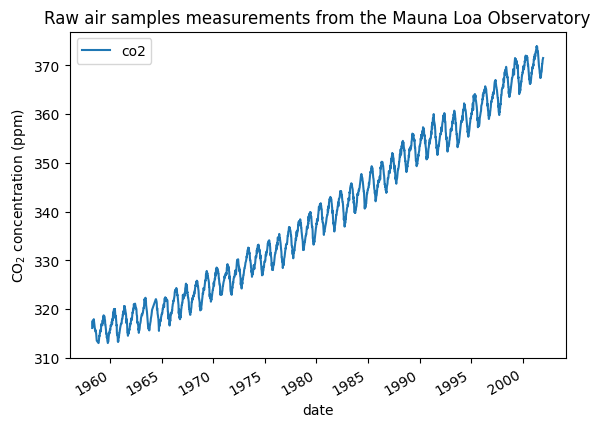

In [18]:
import matplotlib.pyplot as plt

co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

We will preprocess the dataset by taking a monthly average and drop month for which no measurements were collected. Such a processing will have an smoothing effect on the data.

/tmp/ipykernel_438696/4051184181.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")


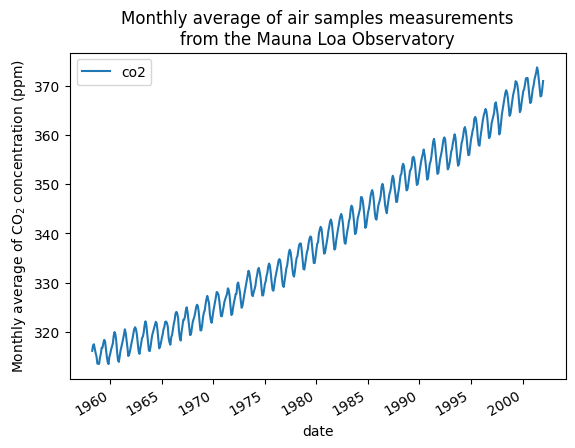

In [19]:
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

The idea in this example will be to predict the CO2 concentration in function of the date. We are as well interested in extrapolating for upcoming year after 2001.

As a first step, we will divide the data and the target to estimate. The data being a date, we will convert it into a numeric.

In [20]:
X = torch.from_numpy((co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1))
y = torch.from_numpy(co2_data["co2"].to_numpy())

### **Design the proper covariance function**


To design the covariance function to use with our Gaussian process, we can make some assumption regarding the data at hand. We observe that they have several characteristics: we see a long term rising trend, a pronounced seasonal variation and some smaller irregularities. We can use different appropriate covariance functions that would capture these features.

First, the long term rising trend could be fitted using a radial basis function (RBF) covariance function with a large length-scale parameter. The RBF kernel with a large length-scale enforces this component to be smooth. A trending increase is not enforced as to give a degree of freedom to our model. The specific length-scale and the amplitude are free hyperparameters.

In [21]:
long_term_trend_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
long_term_trend_cov.base_kernel.initialize(lengthscale = 50.0)
long_term_trend_cov.initialize(outputscale = 50**2)


ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

The seasonal variation is explained by the periodic exponential sine squared covariace function with a fixed periodicity of 1 year. The length-scale of this periodic component, controlling its smoothness, is a free parameter. In order to allow decaying away from exact periodicity, the product with an RBF covariance function is taken. The length-scale of this RBF component controls the decay time and is a further free parameter. This type of covariance function is also known as locally periodic covariance function.

In [22]:
rbf_covariance = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
rbf_covariance.base_kernel.initialize(lengthscale = 100.0)
rbf_covariance.initialize(outputscale = 2.0**2)
exp_sine_covariance = gpytorch.kernels.PeriodicKernel()
exp_sine_covariance.initialize(lengthscale = 1.0)
exp_sine_covariance.initialize(period_length = 1.0)

seasonal_covariance = rbf_covariance * exp_sine_covariance

The small irregularities are to be explained by a rational quadratic kernel component, whose length-scale and alpha parameter, which quantifies the diffuseness of the length-scales, are to be determined. A rational quadratic kernel is equivalent to an RBF kernel with several length-scales and will better accommodate the different irregularities.

In [23]:
irregularities_covariance = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(alpha_consraint=1.0))
irregularities_covariance.base_kernel.initialize(lengthscale = 1.0)
irregularities_covariance.initialize(outputscale = 0.5**2)

ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

Finally, the noise in the dataset can be accounted with a kernel consisting of an RBF kernel contribution, which shall explain the correlated noise components such as local weather phenomena. The relative amplitudes and the RBF’s length scale are further free parameters.



In [24]:
extra_noise_covariance =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
extra_noise_covariance.base_kernel.initialize(lengthscale = 0.1)
extra_noise_covariance.initialize(outputscale = 0.1**2)


ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

Thus, our final kernel is an addition of all previous kernels.



In [25]:
co2_cov_function = long_term_trend_cov + seasonal_covariance + irregularities_covariance + extra_noise_covariance

### **Fitting the GP Model**

We fit the model and plot predictions. We use L-BFGS to find the best model hyper-parameters by optimizing the marginal likelihood.

In [26]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1
mean_y = y.mean()
model = ExactGPModel(X, y - mean_y, likelihood)
model.covar_module = co2_cov_function # We use the specific covariance function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train_model(model):

  model.train()

  # Instantiate the LBFGS optimizer, which will optimize the hyper-parameters.

  optimizer = torch.optim.LBFGS(model.parameters(), \
      history_size=10, max_iter=4, line_search_fn="strong_wolfe")

  def closure():
      optimizer.zero_grad()
      output = model(X)
      loss = -mll(output, y-mean_y)
      loss.backward()
      return loss

  training_iter = 50

  for i in range(training_iter):

    loss = -mll(model(X), y - mean_y)
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

    optimizer.step(closure)

train_model(model)


Iter 1/50 - Loss: 9.639
Iter 2/50 - Loss: 9.449
Iter 3/50 - Loss: 0.416
Iter 4/50 - Loss: 0.323
Iter 5/50 - Loss: 0.323
Iter 6/50 - Loss: 0.313
Iter 7/50 - Loss: 0.248
Iter 8/50 - Loss: 0.247
Iter 9/50 - Loss: 0.247
Iter 10/50 - Loss: 0.247
Iter 11/50 - Loss: 0.241
Iter 12/50 - Loss: 0.235
Iter 13/50 - Loss: 0.235
Iter 14/50 - Loss: 0.235
Iter 15/50 - Loss: 0.234
Iter 16/50 - Loss: 0.223
Iter 17/50 - Loss: 0.223
Iter 18/50 - Loss: 0.223
Iter 19/50 - Loss: 0.223
Iter 20/50 - Loss: 0.222
Iter 21/50 - Loss: 0.221
Iter 22/50 - Loss: 0.221
Iter 23/50 - Loss: 0.221
Iter 24/50 - Loss: 0.221
Iter 25/50 - Loss: 0.221
Iter 26/50 - Loss: 0.221
Iter 27/50 - Loss: 0.221
Iter 28/50 - Loss: 0.220
Iter 29/50 - Loss: 0.220
Iter 30/50 - Loss: 0.220
Iter 31/50 - Loss: 0.220
Iter 32/50 - Loss: 0.220
Iter 33/50 - Loss: 0.220
Iter 34/50 - Loss: 0.220
Iter 35/50 - Loss: 0.220
Iter 36/50 - Loss: 0.220
Iter 37/50 - Loss: 0.220
Iter 38/50 - Loss: 0.220
Iter 39/50 - Loss: 0.220
Iter 40/50 - Loss: 0.220
Iter 41/5

We compute predictions for new data points.

In [27]:
model.eval()

import datetime
import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = torch.from_numpy(np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1))
with torch.no_grad():
  result = model(X_test)
mean_y_pred = (result.mean + mean_y).numpy()
std_y_pred = torch.sqrt(result.variance).numpy()


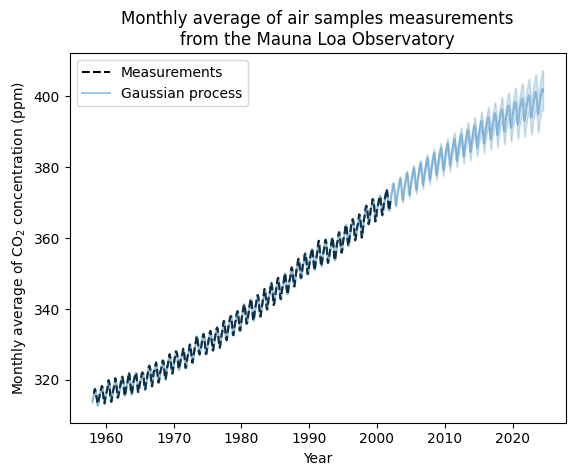

In [28]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

We inspect the resulting covariance function.

In [29]:
print("Long Term Cov. RBF, outputscale:", model.covar_module.kernels[0].outputscale)
print("Long Term Cov. RBF, lengthscale:", model.covar_module.kernels[0].base_kernel.lengthscale, "\n")

print("Seasonal Cov. RBF, outputscale:", model.covar_module.kernels[1].kernels[0].outputscale)
print("Seasonal Cov. RBF, lengthscale:", model.covar_module.kernels[1].kernels[0].base_kernel.lengthscale)
print("Seasonal Cov. PeriodicKernel, lengthscale:", model.covar_module.kernels[1].kernels[1].lengthscale)
print("Seasonal Cov. PeriodicKernel, period:", model.covar_module.kernels[1].kernels[1].period_length, "\n")

print("Irregularities, outputscale:", model.covar_module.kernels[2].outputscale)
print("Irregularities, lengthscale:", model.covar_module.kernels[2].base_kernel.lengthscale, "\n")

print("Extra Noise, outputscale:", model.covar_module.kernels[3].outputscale)
print("Extra Noise, lengthscale:", model.covar_module.kernels[3].base_kernel.lengthscale, "\n")

print("Likelihood noise:", model.likelihood.noise)


Long Term Cov. RBF, outputscale: tensor(2500.0000, grad_fn=<SoftplusBackward0>)
Long Term Cov. RBF, lengthscale: tensor([[50.1337]], grad_fn=<SoftplusBackward0>) 

Seasonal Cov. RBF, outputscale: tensor(4.6201, grad_fn=<SoftplusBackward0>)
Seasonal Cov. RBF, lengthscale: tensor([[99.9886]], grad_fn=<SoftplusBackward0>)
Seasonal Cov. PeriodicKernel, lengthscale: tensor([[1.7324]], grad_fn=<SoftplusBackward0>)
Seasonal Cov. PeriodicKernel, period: tensor([[0.9996]], grad_fn=<SoftplusBackward0>) 

Irregularities, outputscale: tensor(0.3315, grad_fn=<SoftplusBackward0>)
Irregularities, lengthscale: tensor([[1.0401]], grad_fn=<SoftplusBackward0>) 

Extra Noise, outputscale: tensor(0.0349, grad_fn=<SoftplusBackward0>)
Extra Noise, lengthscale: tensor([[0.1246]], grad_fn=<SoftplusBackward0>) 

Likelihood noise: tensor([0.0370], grad_fn=<AddBackward0>)


Thus, most of the target signal, with the mean subtracted, is explained by a long-term rising trend for ~sqrt(2500)ppm and a length-scale of ~50.1337 years. The periodic component has an amplitude of ~sqrt(4.6201)ppm, a decay time of ~sqrt(99.9) years and a length-scale of ~1.73. The long decay time indicates that we have a component very close to a seasonal periodicity. The correlated noise has an amplitude of ~sqrt(0.0349) ppm with a length scale of ~0.12 years and a white-noise contribution of ~0.036 ppm. Thus, the overall noise level is very small, indicating that the data can be very well explained by the model.

## **Task 3**

To check the importance of choosing an adequate covariance function to explain the data, try to change the covariance function used in the previous problem (e.g., simply by using a squared exponential covariance function) and recompute the predictive distribution. Compare also the estimates of the marginal likelihood.

## **Classification**

In this section, we explain how to use GPytorch for classification using the Laplace approximation. Importantly, the Laplace approximation is not implemented in GPytorch. However, GPytorch is flexible enough so that it can be easily extended to consider it. We will consider the sigmoid function to obtain class probabilities. Therefore, we will restrict to binary classification problems. We assume binary class labels in \{0,1\}.

### **Setting Up the Training Data**

We generate first some synthetic data in a two dimensional space. The problem considered is the XOR problem, which is non-linear.

In [30]:
# We generate random data uniformly in the unit box with a fixed random seed.

n_train = 200

torch.random.manual_seed(0)

x1 = torch.rand(n_train, 1) - 0.5
x2 = torch.rand(n_train,1) - 0.5

# We define the target function which generates the class label.

data_fn = lambda x1, x2: (torch.sign(torch.sign(x1) * torch.sign(x2)) + 1.0) * 0.5

# We generate the observed data.

latent_fn = data_fn(x1, x2)
train_y_c = torch.round(latent_fn).long().squeeze()
train_x_c = torch.cat((x1, x2),dim=1)
color = np.array(["red", "blue"])[ train_y_c.numpy() ]
train_y_c = train_y_c.float()


We now plot the data for visualization.

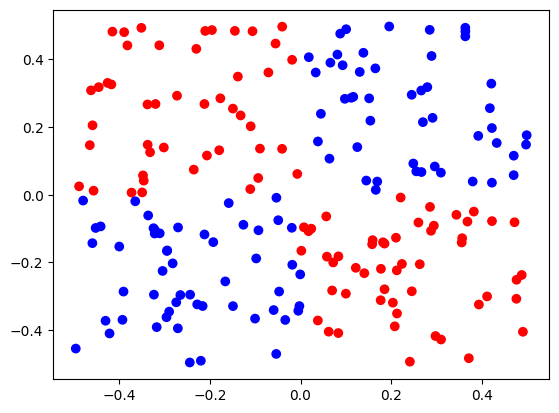

In [31]:
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)


### **Defining the Custom GP Model**

We describe a custom GP model called LaplaceGPModel that implements classifications tasks using the Laplace approximation.


In [32]:
# We create a class called LaplaceGPModel that inherits from ExactGP, sets custom
# mean and covariance functions, and which will be used for classification.

class LaplaceGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, lengthscale = 1.0):

        noise = 1e-4 * torch.ones(train_x.shape[ 0 ])
        likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise)

        # We call the superclass with the training data and the associated
        # likelihood which has almost no-noise.

        super(LaplaceGPModel, self).__init__(train_x, train_y, likelihood)
        self.likelihood = likelihood

        # We consider a constant zero mean and an RBF kernel

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module.base_kernel.initialize(lengthscale = lengthscale)
        self.covar_module.initialize(outputscale = 1.0)

        # We store training data

        self.train_x = train_x
        self.train_y = train_y

        # We define new parameters which are the latent process values at the
        # training points to be optimized to find the posterior's mode.

        self.register_parameter(name="latent_process_values", \
            parameter=Parameter(torch.ones(train_x.shape[ 0 ]) * 0.1 * (train_y * 2.0 - 1.0)))

        # We store the sigmoid function

        self.sigmoid = torch.nn.Sigmoid()

    def evaluate_neg_log_posterior(self):

      mean_x = self.mean_module(self.train_x)
      covar_x = self.covar_module(self.train_x)

      self.likelihood.noise = torch.ones(self.train_x.shape[ 0 ]) * 1e-6

      # We return the negative log posterior probability when considering a sigmoid
      # activation function. The reason is that ADAM minimizes instead of maximizing.

      return -1.0 * (self.likelihood(gpytorch.distributions.MultivariateNormal(mean_x, \
          covar_x)).log_prob(self.latent_process_values) + \
          torch.sum(torch.log(self.sigmoid(self.latent_process_values * (self.train_y * 2.0 - 1.0)))))

    def forward(self, x):

        # The forward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        pi = self.sigmoid(self.latent_process_values)

        # The Laplace approximation can be understood as a Gaussian
        # approximation of the sigmoid factors at the mode. The second
        # derivative of the sigmoid is - pi(1 - pi), with pi the vector
        # of probabilities.

        self.likelihood.noise = 1.0 / (pi * (1 - pi))

        # The targets are the found process values that maximize the posterior

        self.train_targets = self.latent_process_values.detach()

        # We return a multivariate Gaussian distribution with the corresponding
        # prior mean and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def evaluate_log_marginal_likelihood(self):

        covar_x = self.covar_module(self.train_x)
        pi = self.sigmoid(self.latent_process_values * (self.train_y * 2.0 - 1.0))
        A = torch.diag(pi * (1 - pi)) + \
          torch.linalg.inv(torch.eye(self.train_x.shape[ 0 ]) * 1e-6 + \
          covar_x.representation()[ 0 ])

        # We return the estimate of the marginal likelihood by the Laplace
        # approximation.

        return -1.0 * self.evaluate_neg_log_posterior() + 0.5 * \
          self.train_x.shape[ 0 ] * torch.log(torch.ones(1) * 2 * 3.1415926) \
          - 0.5 * torch.logdet(A)

# We create the model again with the new prior mean and covariance function.

model = LaplaceGPModel(train_x_c, train_y_c, lengthscale = 0.25)

### **Finding the Posterior Mode**

The next step is finding the mode of the log posterior. For that, we use LBFGS, a quasi-Newton optimization algorithm, and the model just created.

In [33]:
def train_model(model):

  model.train()

  # Use instantiate the LBFGS optimizer, which will optimize the latent process values
  # to find the posterior mode.

  optimizer = torch.optim.LBFGS([ model.latent_process_values ], \
      history_size=10, max_iter=4, line_search_fn="strong_wolfe")

  def closure():
      optimizer.zero_grad()
      loss = model.evaluate_neg_log_posterior()
      loss.backward()
      return loss

  training_iter = 1000

  for i in range(training_iter):

    loss = model.evaluate_neg_log_posterior()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))

    optimizer.step(closure)

train_model(model)

Iter 1/1000 - Loss: 72526.548
Iter 2/1000 - Loss: -370.660
Iter 3/1000 - Loss: -634.744
Iter 4/1000 - Loss: -687.256
Iter 5/1000 - Loss: -701.602
Iter 6/1000 - Loss: -706.045
Iter 7/1000 - Loss: -711.209
Iter 8/1000 - Loss: -716.367
Iter 9/1000 - Loss: -718.972
Iter 10/1000 - Loss: -720.813
Iter 11/1000 - Loss: -722.516
Iter 12/1000 - Loss: -724.078
Iter 13/1000 - Loss: -724.864
Iter 14/1000 - Loss: -725.783
Iter 15/1000 - Loss: -726.389
Iter 16/1000 - Loss: -726.891
Iter 17/1000 - Loss: -727.379
Iter 18/1000 - Loss: -727.823
Iter 19/1000 - Loss: -728.111
Iter 20/1000 - Loss: -728.495
Iter 21/1000 - Loss: -728.704
Iter 22/1000 - Loss: -728.850
Iter 23/1000 - Loss: -728.941
Iter 24/1000 - Loss: -729.031
Iter 25/1000 - Loss: -729.168
Iter 26/1000 - Loss: -729.223
Iter 27/1000 - Loss: -729.243
Iter 28/1000 - Loss: -729.273
Iter 29/1000 - Loss: -729.296
Iter 30/1000 - Loss: -729.319
Iter 31/1000 - Loss: -729.344
Iter 32/1000 - Loss: -729.390
Iter 33/1000 - Loss: -729.460
Iter 34/1000 - Los

### **Obtaining the Estimate of the Log Marginal Likelihood**

We evaluate the estimate of the log marginal likelihood given by the Laplace approximation.

In [34]:
model.evaluate_log_marginal_likelihood()

tensor([-75.4406], grad_fn=<SubBackward0>)

### **Computing the Predictive Distribution**

After training the model and computing the Laplace approximation we can compute an approximate predictive distribution. For this, we only have to sample from the GP posterior approximation at the test point and marginalize the class probabilities given by the sigmoid fucntion. This marginalization is intractable, but it can be approximated via Monte Carlo, by sampling.

First, we generate the test data.

In [35]:
x1_test = torch.linspace(-1, 1, 20)
x2_test = torch.linspace(-1, 1, 20)
test_x_c = torch.cartesian_prod(x1_test, x2_test)

We set the model in evaluation mode and compute latent predictions.

In [36]:
model.eval()

# For each number of samples we generate posterior class probabilities

with torch.no_grad():
  latent_process_values = model(test_x_c)

# We approximate the sigmoid function by a re-escaled probit function.
# See (Bishop, 2006) page 219.

class_probs = 0.5 * (1 + torch.erf((latent_process_values.mean / \
  torch.sqrt(latent_process_values.variance + 3.1415926 / 8)) / math.sqrt(2)))

We compute now the test error to see what is the generalization performance of the previous classifier.

In [37]:
test_labels = data_fn(test_x_c[:,0:1], test_x_c[:,1:2])
test_error = torch.mean(((class_probs > 0.5).type(torch.DoubleTensor) \
    != test_labels[:,0]).type(torch.DoubleTensor))
print('Test error: %.3f' % test_error)

Test error: 0.003


We plot the predictive distribution. That is the estimated class posterior probability for each potential label.





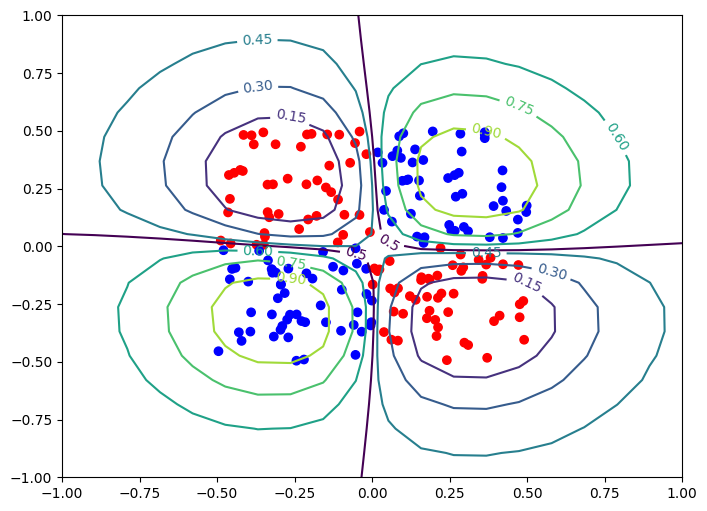

In [38]:
fig, ax = plt.subplots(figsize = (8, 6))
CS = ax.contour(x1_test.numpy(), x2_test.numpy(), class_probs.numpy().reshape((20,20)))
ax.clabel(CS, inline=True, fontsize=10)
CS = ax.contour(x1_test.numpy(), x2_test.numpy(), class_probs.numpy().reshape((20,20)), levels = [0.5])
ax.clabel(CS, inline=True, fontsize=10)
plt.scatter(train_x_c[:,0].numpy(), train_x_c[:,1].numpy(), c = color)

We observe that the class posterior probability is high in regions where there are data instances of each class label and it becomes closer to 0.5 near the decision boundary and as we move away from the data, as expected.

## **Task 4**

We will explore again the utility of the marginal likelihood for model selection. In this task, you are asked to re-fit the previous model for different values of the lengthscale parameter. Try the values \{0.1, 0.25, 1.0\} and observe the estimate of the marginal likelihood and the test error computed above. Do you observe a correlation between the test error and the estimate of the log-marginal likelhood?